In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cos, sin
from gym import spaces
from gym.error import DependencyNotInstalled
from typing import Optional
from control.matlab import ss, lsim, linspace, c2d
from functools import partial
from state_estimation import Estimator
import math
import gym
from stable_baselines3 import PPO, SAC, TD3, DDPG, DQN, A2C
from stable_baselines3.common.env_checker import check_env
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from sklearn.preprocessing import StandardScaler


KeyboardInterrupt: 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class DCEnv1(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(DCEnv1, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 2.0, 0, 0])
        self.obstacles = [np.array([math.pi / 4.0, 0, 0])]
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.5 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.2 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
#         self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = random.randint(10, 50)
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        obs_dists = [np.linalg.norm(self.xmeasure - obstacle) for obstacle in self.obstacles]
        reward = self.target_norm_radius - dist
#         obs_reward = obs_dist-self.safe_norm_radius
        
        self.reward_cache.append(reward)
#         self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
#         if self.steps < 10:
#             avoid_reward = min(self.avoid_reward_cache)
#         else:
#             avoid_reward = min(self.avoid_reward_cache[-10:])          
                    
#         # very strict reward, always within target
#         strict_avoid_reward = avoid_reward - 0.5 * self.safe_norm_radius # half safe norm radius
#         strict_reach_reward = reach_reward - 0.5 * self.target_norm_radius # half target norm radius
        
        # overall reward, pick one of the final_reward
#         final_reward = reach_reward
#         final_reward = approach_reward
#         final_reward = min(reach_reward, avoid_reward) # reach and avoid
#         final_reward = min(approach_reward, avoid_reward) # approach and avoid
#         final_reward = min(reach_reward, approach_reward) # reach and approach
#         deadline_reward = (self.last_dist-dist)/(self.step_const - self.steps+1) 
        final_reward = reach_reward
        # split cases: if already inside target, give very large constant reward for maintaining
#         if dist <= self.target_norm_radius:
#             final_reward = 10 # this gives 39/50 sucess with reach+approach+avoid
        
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or min(obs_dists)<=self.safe_norm_radius or dist>5:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi, random.random()*2-1, random.random()*2-1])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
#         self.step_const = random.randint(10, 50) # deadline range
        self.step_const = 100
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#settings
target_norm_radius = 0.5 # norm ball radius of target, tune this
safe_norm_radius = 0.2
kernel = 1.0 * RBF(1.0)
num_epi= 200
num_steps = 200
action_list = [-10, -5,-2, 2, 5, 10]
delta_tolerance = 0.5
discount = 0.9
center = np.array([math.pi / 2.0, 0, 0])
obstacles = np.array([math.pi / 4.0, 0, 0])
rmax = target_norm_radius
mean_offset = target_norm_radius/(1-discount)
# initial the env
env = DCEnv1()
state = env.reset()
lpschitz = 2
#Initial data collection
initial_buffer = 50
epsilon = 0.05
data_buffer = [[],[],[],[], [], []]
for i in range(initial_buffer):
    this_action = random.randint(0,5)
    new_state, reward, done, _ = env.step([action_list[this_action]])
    data_buffer[this_action].append((state, reward))
    state = new_state

In [5]:
trainx_1 = np.array([tuple[0] for tuple in data_buffer[0]])
trainx_2 = np.array([tuple[0] for tuple in data_buffer[1]])
trainx_3 = np.array([tuple[0] for tuple in data_buffer[2]])
trainx_4 = np.array([tuple[0] for tuple in data_buffer[3]])
trainx_5 = np.array([tuple[0] for tuple in data_buffer[4]])
trainx_6 = np.array([tuple[0] for tuple in data_buffer[5]])
trainy_1 = np.array([tuple[1] for tuple in data_buffer[0]])
trainy_2 = np.array([tuple[1] for tuple in data_buffer[1]])
trainy_3 = np.array([tuple[1] for tuple in data_buffer[2]])
trainy_4 = np.array([tuple[1] for tuple in data_buffer[3]])
trainy_5 = np.array([tuple[1] for tuple in data_buffer[4]])
trainy_6 = np.array([tuple[1] for tuple in data_buffer[5]])
train_x_list = [trainx_1, trainx_2, trainx_3, trainx_4, trainx_5, trainx_6]
train_y_list = [trainy_1, trainy_2, trainy_3, trainy_4, trainy_5, trainy_6]
x_scaler_list = []
for i in range(len(action_list)):
    x_scaler = StandardScaler()
    train_x_list[i] = x_scaler.fit_transform(train_x_list[i])
    x_scaler_list.append(x_scaler)

In [6]:
gpc1 = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpc2 = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpc3 = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpc4 = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpc5 = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpc6 = GaussianProcessRegressor(kernel=kernel, random_state=0)
reward_q1 = []
reward_q2 = []
reward_q3 = []
reward_q4 = []
reward_q5 = []
reward_q6 = []
gpclist = [gpc1,gpc2,gpc3,gpc4, gpc5,gpc6]
reward_q_list = [reward_q1,reward_q2, reward_q3, reward_q4, reward_q5, reward_q6]
i = 0
for i in range(len(action_list)):
    gpclist[i].fit(train_x_list[i], train_y_list[i])
results = [0]*6
new_results = [0]*6
std_list_1 = [0]*6

In [7]:
i = 0
for i in range(num_epi):
    print(i)
    for j in range(num_steps):
        # max q_st
        for k in range(len(reward_q_list)):
            state_entry = state.reshape(1,-1)
            state_entry_scale = x_scaler_list[k].transform(state_entry)
            if reward_q_list[k] == []:
                results[k], std_list_1[k] = gpclist[k].predict(state_entry_scale, return_std=True)
            else:
                lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - state_entry) for point in reward_q_list[k]]
                results[k], std_list_1[k] = gpclist[k].predict(state_entry_scale, return_std=True)
                results[k] = min(min(lp_values), results[k])
                
#         if reward_q1 == []:
#             state_entry = state.reshape(1,-1)
#             value_result1, std1 = gpc1.predict(state_entry, return_std=True)
#         else:
#             state_entry = state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - state_entry) for point in reward_q1]
#             value_result1, std1 = gpc1.predict(state_entry, return_std=True)
#             value_result1 = min(min(lp_values), value_result1)
#         if reward_q2 == []:
#             state_entry = state.reshape(1,-1)
#             value_result2, std2 = gpc2.predict(state_entry, return_std=True)
#         else:
#             state_entry = state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - state_entry) for point in reward_q2]
#             value_result2, std2 = gpc2.predict(state_entry, return_std=True)
#             value_result2 = min(min(lp_values), value_result2)        
#         if reward_q3 == []:
#             state_entry = state.reshape(1,-1)
#             value_result3, std3 = gpc3.predict(state_entry, return_std=True)
#         else:
#             state_entry = state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - state_entry) for point in reward_q3]
#             value_result3, std3 = gpc3.predict(state_entry, return_std=True)
#             value_result3 = min(min(lp_values), value_result3)        
#         if reward_q4 == []:
#             state_entry = state.reshape(1,-1)
#             value_result4, std4 = gpc4.predict(state_entry, return_std=True)
#         else:
#             state_entry = state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - state_entry) for point in reward_q4]
#             value_result4, std4 = gpc4.predict(state_entry, return_std=True)
#             value_result4 = min(min(lp_values), value_result4)
        # get actions
        # get new values
#         results = np.array([value_result1, value_result2, value_result3, value_result4])
#         results = np.array([x+mean_offset for x in results])
        which_action = action_list[np.argmax(results)]
        new_state, reward, done, _ = env.step([which_action])
        k = 0
        for k in range(len(reward_q_list)):
            new_state_entry = new_state.reshape(1,-1)
            new_state_entry_scale = x_scaler_list[k].transform(new_state_entry)
            if reward_q_list[k] == []:
                new_results[k], std_list_1[k] = gpclist[k].predict(new_state_entry_scale, return_std=True)
            else:
                lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - new_state_entry) for point in reward_q_list[k]]
                new_results[k], std_list_1[k] = gpclist[k].predict(new_state_entry_scale, return_std=True)
                new_results[k] = min(min(lp_values), new_results[k])
                
        
#         if reward_q1 == []:
#             new_state_entry = new_state.reshape(1,-1)
#             new_value_result1 = gpc1.predict(new_state_entry)[0]
#         else:
#             new_state_entry = new_state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - new_state_entry) for point in reward_q1]
#             new_value_result1 = gpc1.predict(new_state_entry)[0]
#             new_value_result1 = min(min(lp_values), new_value_result1)
#         if reward_q2 == []:
#             new_state_entry = new_state.reshape(1,-1)
#             new_value_result2 = gpc2.predict(new_state_entry)[0]
#         else:
#             new_state_entry = new_state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - new_state_entry) for point in reward_q2]
#             new_value_result2 = gpc2.predict(new_state_entry)[0]
#             new_value_result2 = min(min(lp_values), new_value_result2)        
#         if reward_q3 == []:
#             new_state_entry = new_state.reshape(1,-1)
#             new_value_result3 = gpc3.predict(new_state_entry)[0]
#         else:
#             new_state_entry = new_state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - new_state_entry) for point in reward_q3]
#             new_value_result3 = gpc3.predict(new_state_entry)[0]
#             new_value_result3 = min(min(lp_values), new_value_result3)        
#         if reward_q4 == []:
#             new_state_entry = state.reshape(1,-1)
#             new_value_result4 = gpc4.predict(new_state_entry)[0]
#         else:
#             new_state_entry = state.reshape(1,-1)
#             lp_values = [point[1]+lpschitz*np.linalg.norm(point[0] - new_state_entry) for point in reward_q4]
#             new_value_result4 = gpc4.predict(new_state_entry)[0]
#             new_value_result4 = min(min(lp_values), new_value_result4)
#         # get the q value
#         new_results = np.array([new_value_result1, new_value_result2, new_value_result3, new_value_result4])
#         new_results = np.array([x+mean_offset for x in new_results])
        
        q_value = reward+discount*max(new_results)
        action_index = np.argmax(results)
        var1 = std_list_1[action_index]**2
#         if which_action == -10:
#             var1 = std1*std1
#         elif which_action == -5:
#             var1 = std2*std2
#         elif which_action == 5:
#             var1 = std3*std3
#         else:
#             var1 = std4*std4
        if var1>delta_tolerance:
            if isinstance(q_value, np.ndarray):
                q_value = q_value[0]
            train_x_list[action_index] = np.vstack([train_x_list[action_index], state_entry])
            train_y_list[action_index] = np.concatenate([train_y_list[action_index], [q_value]])
            x_scaler = StandardScaler()
            train_x_list[action_index] = x_scaler.fit_transform(train_x_list[action_index])
            x_scaler_list[action_index] = x_scaler
            gpclist[action_index].fit(train_x_list[action_index], train_y_list[action_index])
        state_entry_new_scale = x_scaler_list[action_index].transform(state_entry)
        useless_result,update_std = gpclist[action_index].predict(state_entry_new_scale, return_std=True)
        var2 = update_std*update_std
        if (var1>delta_tolerance) and delta_tolerance > var2 and(results[action_index]-useless_result)>2*epsilon:
            reward_q_list[action_index].append((state, useless_result+epsilon))
            for k in range(len(action_list)):
                gpclist[k] = GaussianProcessRegressor(kernel=kernel, random_state=0)
                train_x_list[k] = train_x_list[k][:2]
                train_y_list[k] = train_y_list[k][:2]
        state= new_state
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [8]:
# Testing
# Test 50 traces
env = DCEnv1()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
center = np.array([math.pi / 2.0, 0, 0])
obstacle = np.array([math.pi / 4.0, 0, 0])
num_reached = 0
unsafe = 0
time = 0
for i in range(len(action_list)):
    reward_q_list[i].append((np.array([0,0,0]), np.array([-5])))
for j in range(1000):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    
    # Print initial state
    for i in range(100):
        q1_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q1])
        q2_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q2])
        q3_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q3])
        q4_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q4])
        q5_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q5])
        q6_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q6])
        close_1 = np.argmin(q1_euclids)
        close_2 = np.argmin(q2_euclids)
        close_3 = np.argmin(q3_euclids)
        close_4 = np.argmin(q4_euclids)
        close_5 = np.argmin(q5_euclids)
        close_6 = np.argmin(q6_euclids)
        close_value_list = np.array([reward_q1[close_1][1],reward_q2[close_2][1],reward_q3[close_3][1],reward_q4[close_4][1],reward_q5[close_5][1],reward_q6[close_6][1]])
        action = [action_list[np.argmin(close_value_list)]]
        new_state, reward, done, _ = env.step(action)
        dim0.append(state[0])
        dim1.append(state[1])
        dim2.append(state[2])
        dist = np.linalg.norm(state[:3]-center)
        obs_dist = np.linalg.norm(state[:3]-obstacle)
        euclid.append(dist)
        state = new_state
        if obs_dist <= 0.2:
            unsafe+=1
            break
            time+=100
        if dist <= 0.5: # stop
            num_reached += 1
            time+=i
            break
    dims0.append(dim0)
    dims1.append(dim1)
    dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*100
time+=(1000-num_reached-unsafe)*100
print("Total number reached = " + str(num_reached))
print("Total number collison = " + str(unsafe))
print("Average reach time = " + str(time/1000))

Total number reached = 850
Total number collison = 52
Average reach time = 37.064


In [14]:
# Testing
# Test 50 traces
env = DCEnv1()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
center = np.array([math.pi / 2.0, 0, 0])
obstacle = np.array([math.pi / 4.0, 0, 0])
num_reached = 0
unsafe = 0
time = 0
for i in range(len(action_list)):
    reward_q_list[i].append((np.array([0,0,0]), np.array([-5])))
for j in range(1000):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    
    # Print initial state
    for i in range(50):
        q1_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q1])
        q2_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q2])
        q3_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q3])
        q4_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q4])
        q5_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q5])
        q6_euclids = np.array([np.linalg.norm(state[:3]-x[0])for x in reward_q6])
        close_1 = np.argmin(q1_euclids)
        close_2 = np.argmin(q2_euclids)
        close_3 = np.argmin(q3_euclids)
        close_4 = np.argmin(q4_euclids)
        close_5 = np.argmin(q5_euclids)
        close_6 = np.argmin(q6_euclids)
        close_value_list = np.array([reward_q1[close_1][1],reward_q2[close_2][1],reward_q3[close_3][1],reward_q4[close_4][1],reward_q5[close_5][1],reward_q6[close_6][1]])
        action = [action_list[np.argmin(close_value_list)]]
        new_state, reward, done, _ = env.step(action)
        dim0.append(state[0])
        dim1.append(state[1])
        dim2.append(state[2])
        dist = np.linalg.norm(state[:3]-center)
        obs_dist = np.linalg.norm(state[:3]-obstacle)
        euclid.append(dist)
        state = new_state
        if obs_dist <= 0.2:
            unsafe+=1
            break
            time+=50
        if dist <= 0.5: # stop
            num_reached += 1
            time+=i
            break
    dims0.append(dim0)
    dims1.append(dim1)
    dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*100
time+=(1000-num_reached-unsafe)*50
print("Total number reached = " + str(num_reached))
print("Total number collison = " + str(unsafe))
print("Average reach time = " + str(time/1000))

Total number reached = 636
Total number collison = 46
Average reach time = 27.986


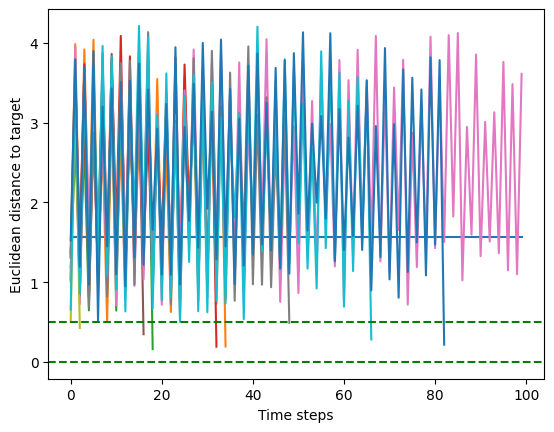

In [9]:
plt.plot(ref)
for i in range(10):
    plt.plot(euclids[i])
plt.axhline(y=0.5, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Euclidean distance to target')
plt.show()

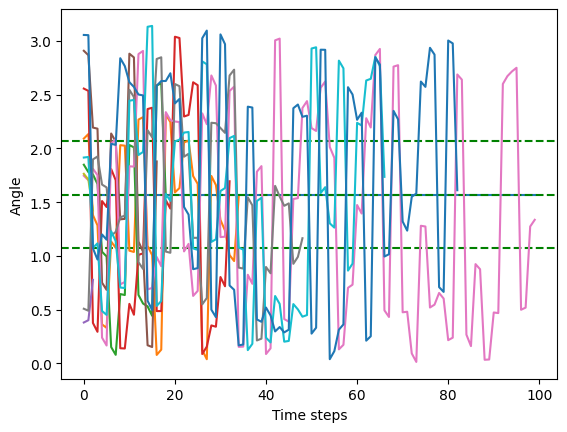

In [10]:
plt.plot(ref)
plt.axhline(y=1.07, color='g', linestyle='--')
plt.axhline(y=1.57, color='g', linestyle='--')
plt.axhline(y=2.07, color='g', linestyle='--')
for i in range(10):
    plt.plot(dims0[i])
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Angle')
plt.show()

In [11]:
import joblib
np.save('q_tab_dc_qs', reward_q_list)
joblib.dump(gpc1, 'dc_gpc1_qs.pkl')
joblib.dump(gpc2, 'dc_gpc2_qs.pkl')
joblib.dump(gpc3, 'dc_gpc3_qs.pkl')
joblib.dump(gpc4, 'dc_gpc4_qs.pkl')
joblib.dump(gpc5, 'dc_gpc5_qs.pkl')
joblib.dump(gpc6, 'dc_gpc6_qs.pkl')

D:\2022_conda\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


['dc_gpc6_qs.pkl']

In [283]:
len(reward_q1)

248

In [284]:
reward_q1

[(array([ 0.25214538, -0.26332606,  0.67064077]), array([-2.60632381])),
 (array([ 0.2203826 , -0.18669194, -2.84673653]), array([-2.60632381])),
 (array([ 0.16078862, -0.41151607, -5.20401673]), array([-2.60632381])),
 (array([ 0.05866479, -0.59953879, -6.78345229]), array([-2.60632381])),
 (array([-0.80370107, -0.18023466, -1.157496  ]), array([-2.09773855])),
 (array([-0.84618873, -0.29769253, -4.07197731]), array([-2.09773855])),
 (array([-1.25757701, -0.03849155,  0.44561409]), array([-2.25173892])),
 (array([-1.27210571, -0.17133258, -2.9978393 ]), array([-2.25173892])),
 (array([-1.331852  , -0.41954236, -5.3052991 ]), array([-2.25173892])),
 (array([-1.43566193, -0.60739643, -6.85131616]), array([-2.25173892])),
 (array([-2.06517189, -0.45922832, -4.14486296]), array([-2.31352043])),
 (array([-2.47762149, -0.22901377, -1.54805103]), array([-3.79034516])),
 (array([-2.64757162, -0.02333662,  0.64299637]), array([-3.71715562])),
 (array([-2.72943746,  0.12766252,  2.77995222]), a